In [18]:
# Importing base libraries
# Importing libraries needed for API requests
# Importing random library for randomizing longitudes
# Importing library which returns the nearest city for given (latitude, longitude)


import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import json
import requests
from config import weather_api_key
import random
from citipy import citipy

In [19]:
# Generate a list of 500 cities for equal latitudes, random longitudes
city_list=[]

#add x iterations through whole range of latitudes
x=2000
for instance in range(int(-x/2),int(x/2)):
    #r corresponding latitude proportional to the number of iterations
    lat=instance*90/(x/2)
    
    #  random longitudes within the whole range
    long=random.uniform(-180,180)
    
    city=citipy.nearest_city(lat,long)
    
    # add only unique items
    if (city.city_name,city.country_code) not in city_list:
        city_list.append((city.city_name,city.country_code))
len(city_list)

# Create a blank dataframe
city_data_df=pd.DataFrame(city_list)
city_data_df=city_data_df.rename(columns={0:"City",1:"Country Code"})
city_data_df["Lat [deg]"]=""
city_data_df["Long [deg]"]=""
city_data_df["Temperature [F]"]=""
city_data_df["Humidity [%]"]=""
city_data_df["Cloudiness [%]"]=""
city_data_df["Wind Speed [mph]"]=""

city_data_df

,City,Country Code,Lat [deg],Long [deg],Temperature [F],Humidity [%],Cloudiness [%],Wind Speed [mph]
0,rikitea,pf,,,,,,
1,busselton,au,,,,,,
2,punta arenas,cl,,,,,,
3,ushuaia,ar,,,,,,
4,hobart,au,,,,,,
...,...,...,...,...,...,...,...,...
772,havoysund,no,,,,,,
773,barentsburg,sj,,,,,,
774,narsaq,gl,,,,,,
775,amderma,ru,,,,,,


In [20]:
# Save config information for API requests
url = "http://api.openweathermap.org/data/2.5/weather?"

#Populating dataframe
not_found=[]
for index,row in city_data_df.iterrows():
    try:
        # Build query URL
        query_url = url + "appid=" + weather_api_key + "&q=" + row["City"]
        # Get weather data
        weather_response = requests.get(query_url).json()
        city_data_df.loc[index,"Lat [deg]"]=weather_response["coord"]["lat"]
        city_data_df.loc[index,"Long [deg]"]=weather_response["coord"]["lon"]
        city_data_df.loc[index,"Temperature [F]"]=weather_response["main"]["temp"]
        city_data_df.loc[index,"Humidity [%]"]=weather_response["main"]["humidity"]
        city_data_df.loc[index,"Cloudiness [%]"]=weather_response["clouds"]["all"]
        city_data_df.loc[index,"Wind Speed [mph]"]=weather_response["wind"]["speed"]
    except:
        # record not found cities and remove from dataframe
        not_found.append(row["City"])
        city_data_df=city_data_df.drop(index)

#print(json.dumps(weather_response, indent=4, sort_keys=True))

#Convert temperature from Kelvin to Fahrenheit
city_data_df["Temperature [F]"]=(city_data_df["Temperature [F]"]-273.15)*9/5+32
city_data_df

,City,Country Code,Lat [deg],Long [deg],Temperature [F],Humidity [%],Cloudiness [%],Wind Speed [mph]
0,rikitea,pf,-23.12,-134.97,77.036,76,19,4.69
1,busselton,au,-33.65,115.33,81.428,29,100,7.54
2,punta arenas,cl,-53.15,-70.92,50,66,78,8.7
3,ushuaia,ar,-54.8,-68.3,53.6,91,40,6.2
4,hobart,au,-42.88,147.33,59.486,47,75,6.2
...,...,...,...,...,...,...,...,...
770,dikson,ru,73.51,80.55,30.056,96,100,7.71
771,college,us,64.86,-147.8,12.758,71,1,1.04
772,havoysund,no,71,24.66,15.8,85,100,11.8
774,narsaq,gl,60.92,-46.05,19.4,79,98,0.59


In [21]:
# Writing dataframe to csv
city_data_df.to_csv(r'analysis_data.csv',index=False)

In [22]:
#defining scatter chart formatting
def scatter_chart(x_values,y_values,x_axis_label,y_axis_label,title,regress):
#     pd.to_numeric(x_values)
#     pd.to_numeric(y_values)
    x_values.astype("float32")
    y_values.astype("float32")

    plt.scatter(x_values,y_values)
    if regress==True:
        (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)

        regress_values = x_values * slope + intercept
        line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
        r_sq="r-sq="+str(round(rvalue,2))
        plt.plot(x_values,regress_values,"r-")
        
        # Indicate annotation position on chart
        x_location=round(np.percentile(x_values,30),0)
        y_location=round(np.percentile(regress_values,30),0)
        
        plt.annotate(line_eq,(x_location,y_location),fontsize=15,color="red")
        plt.annotate(r_sq,(x_location,y_location-10),fontsize=15,color="red")
        #plt.annotate(line_eq,(290,30),fontsize=15,color="red")
        #plt.annotate(r_sq,(280,30),fontsize=15,color="red")
        
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.title(title)
    #saving plots to the Images folder
    plt.savefig(f"Images/{title}.png")
    plt.show()

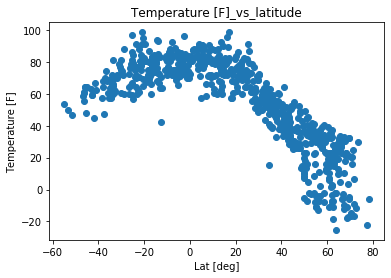

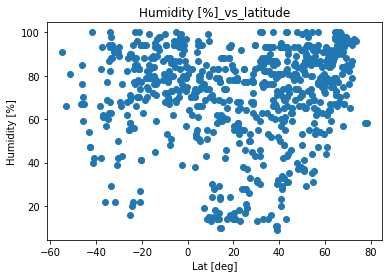

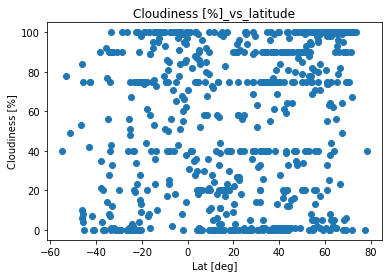

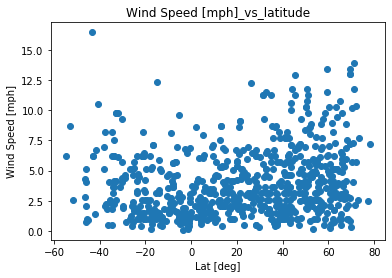

In [23]:
#print overall parameters vs latitude without regression
parameter_vs_latitude=["Temperature [F]","Humidity [%]","Cloudiness [%]","Wind Speed [mph]"]
regress=False

for y_parameter in parameter_vs_latitude:
    x_values=city_data_df["Lat [deg]"]
    y_values=city_data_df[y_parameter]
    x_axis_label="Lat [deg]"
    y_axis_label=y_parameter
    #title=f"{region}:{y_parameter}_vs_latitude"
    title=f"{y_parameter}_vs_latitude"
    scatter_chart(x_values,y_values,x_axis_label,y_axis_label,title,regress)
 


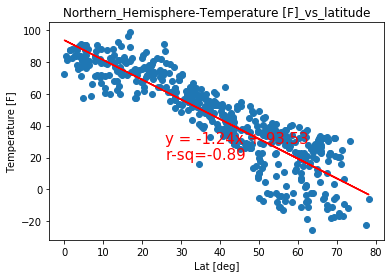

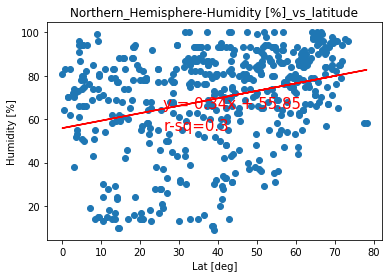

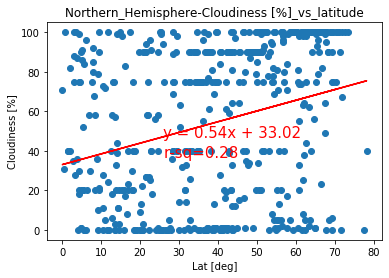

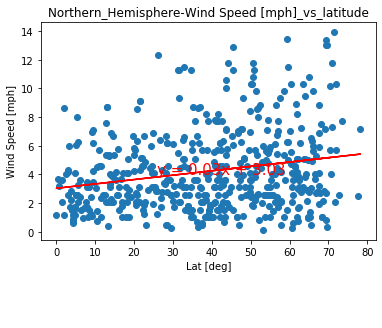

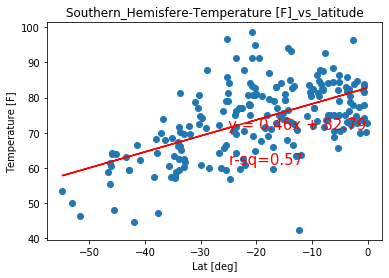

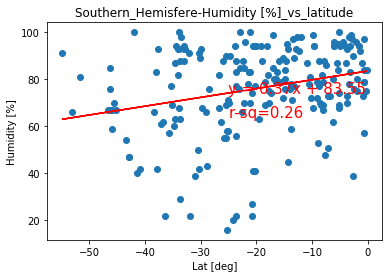

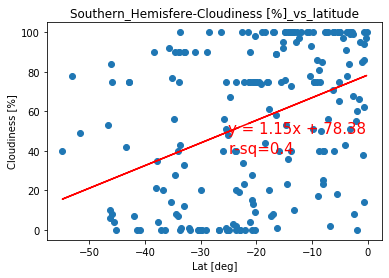

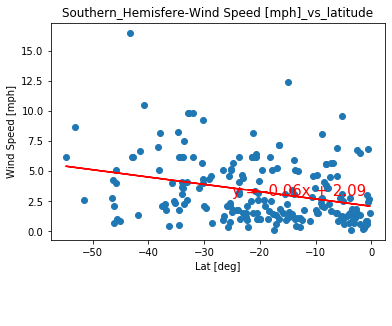

In [24]:
# Divide into northern and southern hemisfere and print with regression
# city_data_df
northern_hemisphere_df=city_data_df[city_data_df["Lat [deg]"]>=0]
southern_hemisphere_df=city_data_df[city_data_df["Lat [deg]"]<0]

regions=["Northern_Hemisphere","Southern_Hemisfere"]
regress=True
for region in regions:
    for y_parameter in parameter_vs_latitude:
        if region=="Northern_Hemisphere":
            data_used_df=northern_hemisphere_df
        elif region=="Southern_Hemisfere":
            data_used_df=southern_hemisphere_df
        x_values=data_used_df["Lat [deg]"].astype("float32")
        y_values=data_used_df[y_parameter].astype("float32")
        x_axis_label="Lat [deg]"
        y_axis_label=y_parameter
        title=f"{region}-{y_parameter}_vs_latitude"
        scatter_chart(x_values,y_values,x_axis_label,y_axis_label,title,regress)
